# Gradient validation [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tumaer/jax-sph/blob/main/notebooks/iclr24_grads.ipynb)

Validating the automatic gradients over multiple SPH solver steps.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import copy

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from jax import grad, jit
from omegaconf import OmegaConf

from jax_sph.case_setup import load_case
from jax_sph.defaults import defaults
from jax_sph.integrator import si_euler
from jax_sph.partition import neighbor_list
from jax_sph.solver import WCSPH

2024-06-13 12:50:32.670124: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
CASES = ["TGV", "LDC"]
STEPS = 5
WARMUP = 10
N = 20

dx = 1.0 / N
dt = 0.0

FD_EPS = 0.001 * dx

In [4]:
def naive_fd_grad(fn, state, neighbors):
    r = state["r"]

    def fn_(x):
        state_ = state.copy()
        state_["r"] = x
        return fn(state_, neighbors)

    actual_grad = jnp.zeros_like(r)
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            f_left = fn_(r)
            f_right = fn_(r.at[i, j].set(r[i, j] + FD_EPS))
            actual_grad = actual_grad.at[i, j].set((f_right - f_left) / FD_EPS)
    return actual_grad


def scipy_fd_grad(fn, state, neighbors):
    shape = state["r"].shape
    r = np.array(state["r"]).flatten()

    def fn_(x):
        state_ = state.copy()
        state_["r"] = jnp.array(x.reshape(*shape))
        return np.array(fn(state_, neighbors)).flatten()

    grads = sp.optimize.approx_fprime(xk=r, f=fn_, epsilon=FD_EPS)
    grads = jnp.array(grads).reshape(*shape)
    return grads

In [5]:
sph_grads = {}
fd_grads = {}
case_shapes = {}
state0s = {}

for ind, case_id in enumerate(CASES):
    cfg = OmegaConf.create({"config": "../cases/" + case_id.lower() + ".yaml"})
    cfg = OmegaConf.merge(defaults.copy(), OmegaConf.load(cfg.config), cfg)
    cfg.seed = 0
    cfg.case.dx = dx
    cfg.case.viscosity = 0.1
    cfg.solver.t_end = 1.0

    Case = load_case(os.path.dirname(cfg.config), cfg.case.source)
    case = Case(cfg)
    (cfg, box_size, state, g_ext_fn, bc_fn, nw_fn, eos_fn, _, displ_fn, shift_fn) = (
        case.initialize()
    )

    dt = cfg.solver.dt

    solver = WCSPH(
        displ_fn,
        eos_fn,
        g_ext_fn,
        cfg.case.dx,
        cfg.case.dim,
        cfg.solver.dt,
        cfg.case.c_ref,
        cfg.solver.is_bc_trick,
    )
    forward = solver.forward_wrapper()

    neighbor_fn = neighbor_list(
        displ_fn,
        box_size,
        r_cutoff=solver._kernel_fn.cutoff,
        mask_self=False,
        num_particles_max=state["r"].shape[0],
        pbc=np.array(cfg.case.pbc),
    )
    neighbors = neighbor_fn.allocate(state["r"], num_particles=state["r"].shape[0])

    solver = si_euler(0.0, forward, shift_fn, bc_fn, nw_fn)
    solver = jit(solver)

    # warm up initial state
    for _ in range(WARMUP):
        state, neighbors = solver(dt, state, neighbors)

    state0s[case_id] = state.copy()

    def solver_fn(state, neighbors):
        state_ = state.copy()
        neighbors_ = copy.deepcopy(neighbors)
        for _ in range(STEPS):
            state_, neighbors_ = solver(dt, state_, neighbors_)
        return (0.5 * state_["u"] ** 2).sum()

    sph_grad = grad(solver_fn, argnums=(0,), allow_int=True)(state, neighbors)[0]["r"]

    fd_grad = scipy_fd_grad(solver_fn, state, neighbors)
    err = ((sph_grad - fd_grad) ** 2).mean()

    sph_grads[case_id] = sph_grad
    fd_grads[case_id] = fd_grad
    ratio = box_size[1] / box_size[0]
    num = int(state["r"].shape[0] ** 0.5) if ratio == 1 else N
    case_shapes[case_id] = (num, int(num * ratio))

    print(f"[{case_id}] Total error (scipy FD) = {err:.6f}")

dt_convective : 0.0011363636363636365
dt_viscous    : 0.006249999999999987
dt_body_force : 3751499.544919711
dt_max_allowed: 0.0011363636363636365
dt_final      : 0.0011363636363636365
Total number of particles =  400
[TGV] Total error (scipy FD) = 0.012760
dt_convective : 0.0011363636363636365
dt_viscous    : 0.006249999999999987
dt_body_force : 3751499.544919711
dt_max_allowed: 0.0011363636363636365
dt_final      : 0.0004
Total number of particles =  676
[LDC] Total error (scipy FD) = 0.000970


## Gradient landscapes

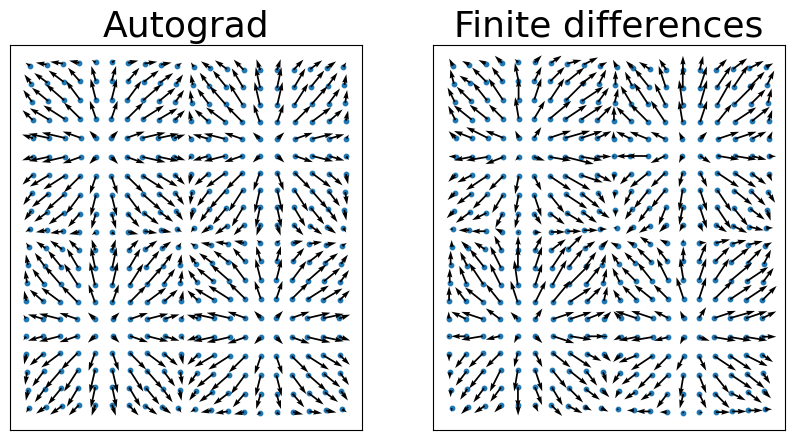

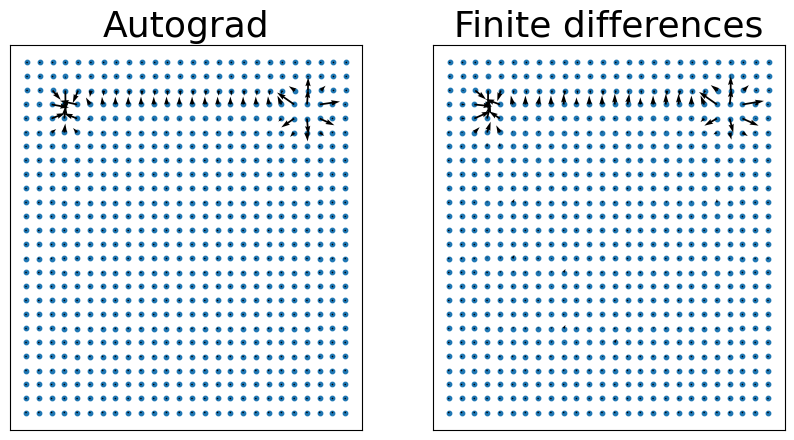

In [6]:
for case_id in sph_grads:
    sph_grad = sph_grads[case_id]
    fd_grad = fd_grads[case_id]
    shape = case_shapes[case_id]
    state0 = state0s[case_id]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    vmin = min(sph_grad.min(), fd_grad.min())
    vmin = vmin * 1.1 if vmin < 0 else vmin * 0.9
    vmax = max(sph_grad.max(), fd_grad.max())
    vmax = vmax * 1.1 if vmax > 0 else vmax * 0.9

    # In the JAX-SPH paper (https://arxiv.org/pdf/2403.04750), we plot the gradients
    # on a grid by simply reshaping the coordinates of the points to a [sqrt(N)]^2 grid.
    # To reproduce the original paper plots, checkout release v0.0.1:
    # https://github.com/tumaer/jax-sph/tree/v0.0.1
    axs[0].scatter(state0["r"][:, 0], state0["r"][:, 1], s=10)
    axs[0].quiver(
        state0["r"][:, 0],
        state0["r"][:, 1],
        sph_grad[:, 0],
        sph_grad[:, 1],
        scale=15,
        width=0.005,
        headwidth=3,
    )
    axs[0].set_title("Autograd", fontsize=26)
    axs[1].scatter(state0["r"][:, 0], state0["r"][:, 1], s=10)
    axs[1].quiver(
        state0["r"][:, 0],
        state0["r"][:, 1],
        fd_grad[:, 0],
        fd_grad[:, 1],
        scale=15,
        width=0.005,
        headwidth=3,
    )
    axs[1].set_title("Finite differences", fontsize=26)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    plt.savefig(
        f"grad_comparison_{case_id}.pdf", bbox_inches="tight", pad_inches=0.1, dpi=300
    )